# 2020 KERC

## 0. Info
* Type : Video Regression
* URL : https://www.kaggle.com/c/2020kerc
* Score
    * Train : 0.175
    * Val : 1.092
    * Test : 0.933

## 1. Setting

In [ ]:
!pip install -q moviepy
!pip install -q face_recognition

In [3]:
import os
from tqdm import tqdm
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import librosa
from PIL import Image
import face_recognition
import moviepy.editor as mp

import tensorflow as tf
import tensorflow_addons as tfa

import albumentations as A

import warnings
warnings.filterwarnings("ignore")

In [17]:
CONFIG = {
    'input_shape' : (128, 128, 3),
    'batch_size' : 32,
    'epoch_size' : 100,
    'base_dir' : 'drive/Shared drives/Yoon/Project/Doing/Korean Sentiment Recognition'
    # 'base_dir' : 'drive/Shared drives/Yoon/Project/Doing/Data Science Competition/Kaggle/2020 KERC'
}

## 2. Data

### 변환

In [ ]:
def mp4_to_jpg(mp4, video_dir, image_dir):
    """mp4 파일을 jpg로 변환

    Parameters:
    mp4 (str) : mp4 파일 경로 (예 : '0403.mp4')
    video_dir (str) : mp4 디렉토리 경로 (예 : 'data/Train')
    image_dir (str) : jpg 디렉토리 경로 (예 : 'data/TrainImage)

    Returns:
    None
    """

    video_num = mp4.split('.')[0][-4:]
    save_dir = os.path.join(image_dir, video_num)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    cap = cv2.VideoCapture(os.path.join(video_dir, mp4))
    idx = 1
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(os.path.join(save_dir, f'{idx}.jpg'), frame)
            idx += 1
        else:
            break


def mp4_to_wav(mp4_dir, wav_dir):
    if not os.path.isdir(wav_dir):
        os.makedirs(wav_dir)
        
    for v in tqdm(os.listdir(mp4_dir)):
        v_name = v.split('.')[0]
        video = mp.VideoFileClip(os.path.join(mp4_dir, v))
        video.audio.write_audiofile(os.path.join(wav_dir, f'{v_name}.wav'), progress_bar=False, verbose=False)


def wav_to_mel(wav_dir, npy_dir):
    if not os.path.isdir(npy_dir):
        os.makedirs(npy_dir)

    for w in tqdm(os.listdir(wav_dir)):
        w_name = w.split('.')[0]
        aud, sr = librosa.load(os.path.join(wav_dir, w))
        mel = librosa.feature.melspectrogram(aud, sr=sr, hop_length=512)         
        np.save(os.path.join(npy_dir, w_name + '.npy'), mel)


def wav_to_mfcc(wav_dir, npy_dir):
    if not os.path.isdir(npy_dir):
        os.makedirs(npy_dir)

    for w in tqdm(os.listdir(wav_dir)):
        w_name = w.split('.')[0]
        aud, sr = librosa.load(os.path.join(wav_dir, w))
        mel = librosa.feature.mfcc(aud, sr=sr, n_mfcc=40)         
        np.save(os.path.join(npy_dir, w_name + '.npy'), mel)


def img_to_face(img_dir, face_dir):
    img_path = glob(img_dir + '/*/*.jpg')
    face_path = [i.replace(img_dir, face_dir) for i in img_path]
        
    for idx in tqdm(range(len(img_path))):
        i, f = img_path[idx], face_path[idx]
        dirname = os.path.dirname(f)
        if not os.path.isdir(dirname):
            os.makedirs(dirname)

        img = face_recognition.load_image_file(i)
        loc = face_recognition.face_locations(img, model='cnn')
        if len(loc) > 0:
            top, right, bottom, left = loc[0]
            face = img[top:bottom, left:right]
            Image.fromarray(face).save(f)

### Dataloader

In [18]:
class TrainDataloader(tf.keras.utils.Sequence):
    def __init__(self, data):
        self.data = data
        self.transform = A.Compose([
            A.ShiftScaleRotate(p=0.5),
        ])

        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.data) / CONFIG['batch_size']).astype(np.int32)

    def on_epoch_end(self):
        self.indices = np.random.permutation(len(self.data))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[CONFIG['batch_size']*idx : CONFIG['batch_size']*(idx+1)]
        batch_data = self.data.iloc[batch_idx]
        batch_y = batch_data[['Valence', 'Arousal', 'Stress1', 'Stress2']].values.astype(np.float32)

        batch_x = [load_train_data(i) for i in batch_data['face_name']]
        batch_x = [self.transform(image=i)['image'] for i in batch_x]
        batch_x = np.stack(batch_x).astype(np.float32) / 255.0
        return batch_x, batch_y


class TestDataloader(tf.keras.utils.Sequence):
    def __init__(self, data):
        self.data = data
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.data)
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.data))
    
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        x = load_test_data(data['face_name'])
        x = np.stack(x).astype(np.float32) / 255.0
        return x, None

def load_train_data(path):
    faces = os.listdir(path)
    random_idx = np.random.randint(len(faces))
    face = tf.keras.preprocessing.image.load_img(os.path.join(path, faces[random_idx]), grayscale=False, target_size=CONFIG['input_shape'])
    face = tf.keras.preprocessing.image.img_to_array(face)
    return face

def load_test_data(path):
    faces = os.listdir(path)
    faces = [os.path.join(path, i) for i in faces]
    faces = [tf.keras.preprocessing.image.load_img(i, grayscale=False, target_size=CONFIG['input_shape']) for i in faces]
    faces = [tf.keras.preprocessing.image.img_to_array(i) for i in faces]
    return faces

def predict(model, dataloader):
    pred = []
    for x, y in dataloader:
        _pred = model(x)
        _pred = np.mean(_pred, axis=0)
        pred.append(_pred)
    pred = np.stack(pred)
    pred[:, 2:] = np.mean(pred[:, 2:], axis=1)[:,None]
    return pred

In [7]:
data_path = os.path.join(CONFIG['base_dir'], 'data/train_face.zip')
!unzip -q '{data_path}'

data_path = os.path.join(CONFIG['base_dir'], 'data/val_face.zip')
!unzip -q '{data_path}'

data_path = os.path.join(CONFIG['base_dir'], 'data/test_face.zip')
!unzip -q '{data_path}'

In [19]:
train_data = pd.read_csv(os.path.join(CONFIG['base_dir'], 'data/train_mean.csv'))
train_data['Stress1'] = train_data['Stress']
train_data['Stress2'] = train_data['Stress']
train_data = train_data.drop('Stress', axis=1)
train_data['face_name'] = train_data['video_name'].apply(lambda x : os.path.join('train_face', x.split('.')[0][-4:]))
train_data = train_data.loc[train_data['face_name'].apply(lambda x : len(os.listdir(x))) > 0]
train_data.head()

,video_name,Valence,Arousal,Stress1,Stress2,face_name
0,Train/0001.mp4,2.5,5.9,7.2,7.2,train_face/0001
1,Train/0002.mp4,3.9,5.0,5.6,5.6,train_face/0002
2,Train/0003.mp4,3.0,6.8,6.6,6.6,train_face/0003
3,Train/0004.mp4,4.0,4.5,5.6,5.6,train_face/0004
4,Train/0005.mp4,1.9,8.5,8.1,8.1,train_face/0005


In [20]:
val_data = pd.read_csv(os.path.join(CONFIG['base_dir'], 'data/val_mean.csv'))
val_data['Stress1'] = val_data['Stress']
val_data['Stress2'] = val_data['Stress']
val_data = val_data.drop('Stress', axis=1)
val_data['face_name'] = val_data['video_name'].apply(lambda x : os.path.join('val_face', x.split('.')[0][-4:]))
val_data.head()

,video_name,Valence,Arousal,Stress1,Stress2,face_name
0,Val/0637.mp4,4.3,5.4,5.6,5.6,val_face/0637
1,Val/0638.mp4,3.3,3.7,6.3,6.3,val_face/0638
2,Val/0639.mp4,3.1,5.4,6.9,6.9,val_face/0639
3,Val/0640.mp4,2.5,5.8,7.2,7.2,val_face/0640
4,Val/0641.mp4,5.0,6.1,4.5,4.5,val_face/0641


In [22]:
train_loader = TrainDataloader(train_data)
x, y = train_loader.__getitem__(0)
x.shape, y.shape

((32, 128, 128, 3), (32, 4))

## 3. Model

In [23]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(OutputLayer, self).__init__()
        self.body = tf.keras.Sequential([
            tf.keras.layers.Dense(4, activation='tanh'),
            tf.keras.layers.Lambda(lambda x : (x + 1) * 4.5)
        ])
    def call(self, x):
        return self.body(x)


class Model(tf.keras.Model):
    def __init__(self, k):
        super(Model, self).__init__()
        self.k = k
        self.base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=CONFIG['input_shape'])
        self.flatten = tf.keras.layers.Flatten( )
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.output_layer = [OutputLayer() for _ in range(k)]

    def call(self, x, training):
        x = self.base(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = [l(x) for l in self.output_layer]
        x = tf.reduce_mean(x, axis=0)
        return x

In [24]:
model = Model(k=5)
model.compile(
    loss = 'mae',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
)

## 4. Train

In [25]:
class EvalCallbacks(tf.keras.callbacks.Callback):
    def __init__(self):
        target_columns = ['Valence', 'Arousal', 'Stress1', 'Stress2']
        self.val_loader = TestDataloader(val_data)
        self.val_true = val_data[target_columns].values
        self.best_loss = 1e3

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0 or epoch == CONFIG['epoch_size']-1:
            val_pred = predict(self.model, self.val_loader)
            val_loss = tf.keras.losses.mse(self.val_true, val_pred).numpy()
            val_loss = tf.reduce_mean(val_loss)
            if val_loss < self.best_loss:
                self.model.save_weights('model.h5')
                self.best_loss = val_loss
            print(f' - val loss: {val_loss:.4f}')

In [26]:
hist = model.fit(
    train_loader,
    epochs = CONFIG['epoch_size'],
    callbacks = [EvalCallbacks()]
)

Epoch 1/100
20/20 [==============================] - 39s 2s/step - loss: 1.4087
Epoch 2/100
20/20 [==============================] - 1s 73ms/step - loss: 1.2834
Epoch 3/100
20/20 [==============================] - 1s 72ms/step - loss: 1.2580
Epoch 4/100
20/20 [==============================] - 1s 73ms/step - loss: 1.2534
Epoch 5/100
20/20 [==============================] - 1s 74ms/step - loss: 1.2344
Epoch 6/100
20/20 [==============================] - 39s 2s/step - loss: 1.2240
Epoch 7/100
20/20 [==============================] - 1s 72ms/step - loss: 1.2166
Epoch 8/100
20/20 [==============================] - 1s 71ms/step - loss: 1.2300
Epoch 9/100
20/20 [==============================] - 1s 70ms/step - loss: 1.2333
Epoch 10/100
20/20 [==============================] - 1s 72ms/step - loss: 1.1839
Epoch 11/100
20/20 [==============================] - 39s 2s/step - loss: 1.1768
Epoch 12/100
20/20 [==============================] - 1s 71ms/step - loss: 1.1997
Epoch 13/100
20/20 [========

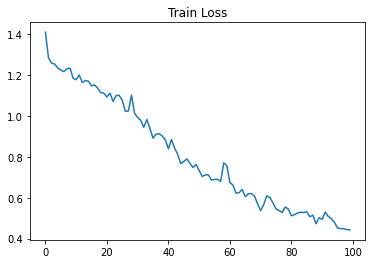

In [27]:
plt.plot(hist.history['loss'])
plt.title('Train Loss')
plt.show()

Train Loss : 0.280 | Val Loss : 1.070


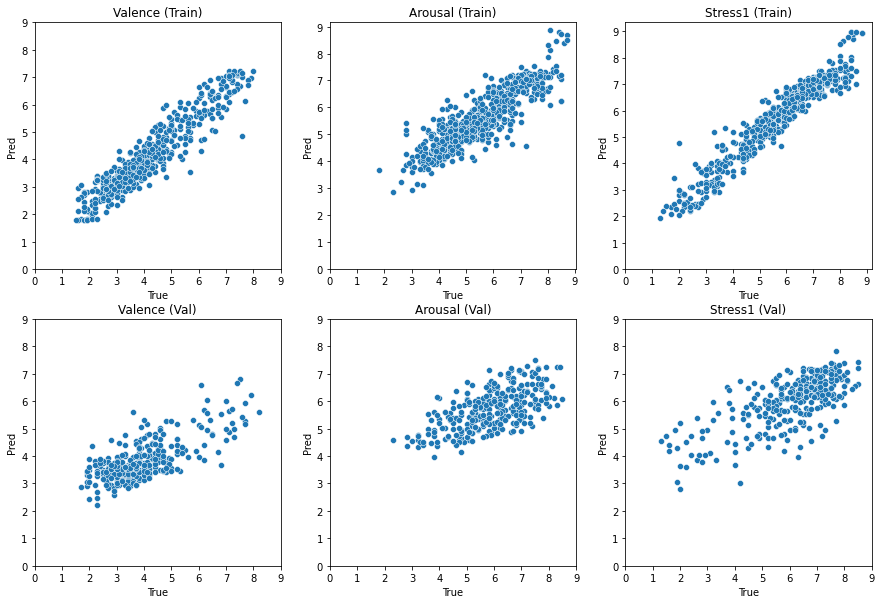

In [29]:
model.load_weights('model.h5')

target_columns = ['Valence', 'Arousal', 'Stress1', 'Stress2']
train_loader = TestDataloader(train_data)
val_loader = TestDataloader(val_data)

train_true = train_data[target_columns].values
train_pred = predict(model, train_loader)
train_loss = np.mean(tf.keras.losses.mse(train_true, train_pred).numpy())

val_true = val_data[target_columns].values
val_pred = predict(model, val_loader)
val_loss = np.mean(tf.keras.losses.mse(val_true, val_pred).numpy())

print(f'Train Loss : {train_loss:.3f} | Val Loss : {val_loss:.3f}')

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    sns.scatterplot(train_true[:,i], train_pred[:,i], ax=ax[0, i])
    ax[0, i].set_title(f'{target_columns[i]} (Train)')
    ax[0, i].set_xlabel('True')
    ax[0, i].set_ylabel('Pred')
    ax[0, i].set_xticks([i for i in range(10)])
    ax[0, i].set_yticks([i for i in range(10)])

    sns.scatterplot(val_true[:,i], val_pred[:,i], ax=ax[1, i])
    ax[1, i].set_title(f'{target_columns[i]} (Val)')
    ax[1, i].set_xlabel('True')
    ax[1, i].set_ylabel('Pred')
    ax[1, i].set_xticks([i for i in range(10)])
    ax[1, i].set_yticks([i for i in range(10)])

plt.show()

## 5. Test

In [30]:
test_data = pd.read_csv(os.path.join(CONFIG['base_dir'], 'data/sample_submission.csv'))
test_data['face_name'] = test_data['video_name'].apply(lambda x : os.path.join('test_face', x.split('.')[0][-4:]))
test_data.head()

,video_name,Valence,Arousal,Stress1,Stress2,face_name
0,001000.mp4,4.0,5.9,6.0,6.0,test_face/1000
1,001001.mp4,4.0,5.9,6.1,6.1,test_face/1001
2,001002.mp4,4.0,5.9,6.0,6.0,test_face/1002
3,001003.mp4,4.0,6.0,6.2,6.2,test_face/1003
4,001004.mp4,4.0,5.9,6.0,6.0,test_face/1004


In [31]:
test_loader = TestDataloader(test_data)
test_pred = predict(model, test_loader)
test_data[target_columns] = test_pred

In [33]:
test_data = test_data.drop('face_name', axis=1)
test_data.to_csv('submission.csv', index=False)
test_data.head()

,video_name,Valence,Arousal,Stress1,Stress2,face_name
0,001000.mp4,3.901995,5.490708,5.927103,5.927103,test_face/1000
1,001001.mp4,3.989360,4.480676,5.679691,5.679691,test_face/1001
2,001002.mp4,3.378717,6.070635,6.698455,6.698455,test_face/1002
3,001003.mp4,3.495615,5.871037,6.571220,6.571220,test_face/1003
4,001004.mp4,4.361662,5.868893,5.112332,5.112332,test_face/1004
